<a href="https://colab.research.google.com/github/mylibui/demo/blob/master/AE_VAE_Modelle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.18.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import datetime
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import os
import pandas as pd
from typing import Union, Tuple, Optional, List, Any,Dict

In [3]:
file_path= 'Data/creditcard.csv'
df = pd.read_csv(file_path)

# Normalize the 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Drop the 'Time' column as it is not useful for anomaly detection
df = df.drop(['Time'], axis=1)

# Separate features and labels
X = df.drop(['Class'], axis=1).values
y = df['Class'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Only use normal transactions for training (Class = 0)
X_train_normal = X_train[y_train == 0]

In [4]:
# Hyperparameters
input_dim = X_train.shape[1]
latent_dim = 16
hidden_dims = [64, 32]  # Two hidden layers with 64 and 32 neurons respectively
epochs = 20
batch_size = 256
epoch=30
learning_rate=0.001
dropout_rate=0.1
activation='mish'
kl_weight=1
classifier_dim=[16]

#I. Unsupervised Autoencoder (AE)


---



## 2.Trainiern AE

In [ ]:
from src.fraud_detection import evaluate_fraud_detection
from src.fraud_detection.threshhold import find_optimal_threshold
from src.models import UnsupervisedAE
from src.plot import plot_latent_space, plot_loss_curves, plot_reconstruction_analysis, plot_roc_auc_curve
uae = UnsupervisedAE(
    input_dim=X_train_normal.shape[1],
    hidden_dims=[64, 32],  # Standardmäßig [64, 32], aber anpassbar
    latent_dim=16,  # Anpassbar
    activation='mish',  # Anpassbar
    dropout_rate=0.1  # Anpassbar
)
uae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

history = uae.fit(
    X_train_normal,
    epochs=epoch,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1
)

uae.print_summary()
fig, axes = plot_loss_curves(
    history,
    model_type=uae.type,
    experiment_name='uae',
)
best_threshold = find_optimal_threshold(uae, X_test, y_test)
plot_reconstruction_analysis(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    threshold=best_threshold,  # Basierend auf Ihren vorherigen Histogram-Daten für AE
    experiment_name='uae'
)
metrics = evaluate_fraud_detection(
    uae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    experiment_name='uae'
)
plot_roc_auc_curve(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    experiment_name='uae')
plot_latent_space(
    uae,
    X_test,
    np.squeeze(y_test),
    experiment_name='uae'
)

Epoch 1/2
711/711 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - reconstruction_loss: 28.1921 - val_reconstruction_loss: 23.5231
Epoch 2/2
194/711 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - reconstruction_loss: 22.6936

#II. Unsupervsied VAE  




---



In [ ]:
from src.models import UnsupervisedVAE
uvae = UnsupervisedVAE(
    input_dim=X_train_normal.shape[1],
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    activation=activation,
    dropout_rate=0.1,
    kl_weight=kl_weight
)
uvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
history_uvae = uvae.fit(
    X_train_normal,
    epochs=epoch,
    batch_size=256,
    validation_split=0.2,
    verbose=0
)
# Ausgabe der Modellzusammenfassung
uvae.print_summary()

In [ ]:
fig, axes = plot_loss_curves(history,model_type='vae',folder_name="vae_results/loss_curves")
metrics_vae = evaluate_fraud_detection(
    uvae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="vae_results/metrics"
)
optimal_threshold, _ = find_optimal_threshold(uvae, X_test, y_test)
plot_reconstruction_analysis(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    threshold=optimal_threshold,  # Verwende den optimalen Schwellenwert
    folder_name="vae_results/reconstruction_analysis"
    )
# Evaluieren der Fraud-Detektion, Metriken ausgeben und speichern
metrics = evaluate_fraud_detection(
    uvae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="vae_results/metrics"
)
plot_roc_auc_curve(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="vae_results")
plot_latent_space(
    uvae,
    X_test,
    np.squeeze(y_test),
    folder_name="vae_results/latent_space"
)

#III. Supervised AE

## 1.Klasse SAE definieren

In [ ]:

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
sae = SupervisedAE(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    classifier_dims=classifier_dim,
    activation='mish',
    dropout_rate=0.1
)
sae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)
history_sae = sae.fit(
    X_train, y_train,  # Tuple mit X_train und y_train
    epochs=epoch,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0
)
sae.print_summary()

In [ ]:
plot_loss_curves(history_sae,model_type='sae',folder_name="sae_results/loss_curves")
plot_reconstruction_analysis(
    sae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="sae_results/reconstruction_analysis"
    )
sae_reconstruction_error = calculate_reconstruction_error(sae, X_test)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Performance:
Accuracy: 0.9993
Precision: 0.7917
Recall: 0.7755
F1 Score: 0.7835


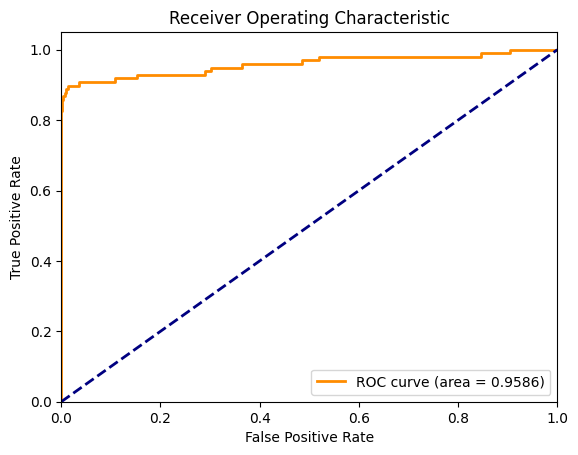

In [ ]:
# Evaluate the classifier on test data
_, y_pred_prob_sae = sae.predict(X_test)
y_pred_sae = (y_pred_prob_sae > 0.5).astype(int)  # Apply threshold at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_sae)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_sae, average='binary')

print(f"Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_sae)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Clasifikation report

In [ ]:
classification_report_sae = classification_report(y_test, y_pred_sae)
print(classification_report_sae)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.79      0.78      0.78        98

    accuracy                           1.00     56962
   macro avg       0.90      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



## 5.Plot latent space

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/sae_results/latent_space/latent_space_SupervisedAE_20250301_070729.png


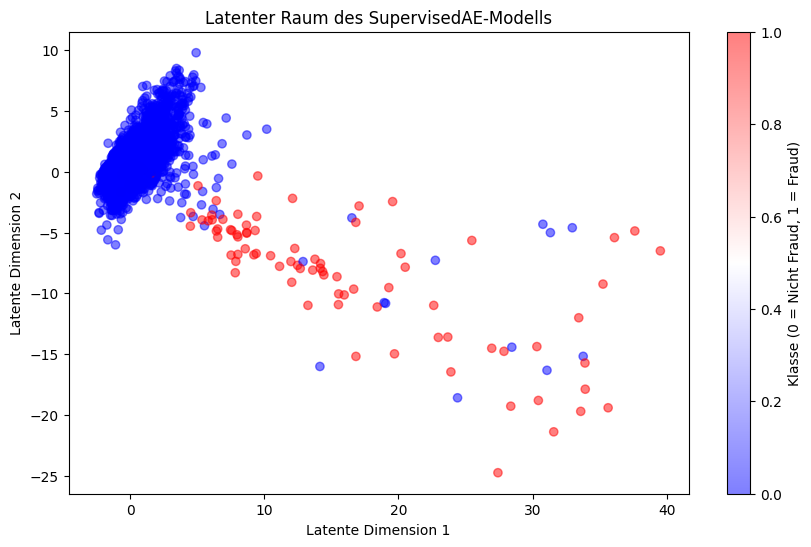

In [ ]:
# Extract the latent representations
plot_latent_space(sae, X_test, y_test, folder_name="sae_results/latent_space")

#IV. Supervised VAE

In [ ]:
# Konvertiere X und y zu float32 für TensorFlow und forme y zu (batch_size, 1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.expand_dims(y_train.astype(np.float32), axis=-1)  # Shape (n_samples, 1)
y_test = np.expand_dims(y_test.astype(np.float32), axis=-1)    # Shape (n_samples, 1)

X_train shape: (227845, 29)
y_train shape: (227845, 1)
y_train unique values: [0. 1.]
y_train dtype: float32
X_train dtype: float32


## 2.Trainieren

In [ ]:
svae = SupervisedVAE(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    classifier_dims=classifier_dim,
    activation=activation,
    dropout_rate=dropout_rate,
    kl_weight=kl_weight
)
svae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
history_svae = svae.fit(
    X_train, y_train,  # Tuple mit X_train und y_train
    epochs=5,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - classification_loss: 0.0885 - kl_loss: 6.3975 - loss: 38.7227 - reconstruction_loss: 32.2367 - val_classification_loss: 0.0061 - val_kl_loss: 0.9666 - val_loss: 30.5193 - val_reconstruction_loss: 29.5466
Epoch 2/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - classification_loss: 0.0056 - kl_loss: 1.0095 - loss: 30.9398 - reconstruction_loss: 29.9247 - val_classification_loss: 0.0052 - val_kl_loss: 1.2147 - val_loss: 30.1172 - val_reconstruction_loss: 28.8973
Epoch 3/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - classification_loss: 0.0051 - kl_loss: 1.3176 - loss: 30.6705 - reconstruction_loss: 29.3478 - val_classification_loss: 0.0050 - val_kl_loss: 1.4806 - val_loss: 29.8421 - val_reconstruction_loss: 28.3566
Epoch 4/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - classification_loss: 0.0044 - kl_loss: 1.4799 - loss: 31.0259 - reconstruction_loss: 29.5416 - val_classification_loss: 0.0040 - val_kl_loss: 1.5054 - val_loss: 29.

In [ ]:
# Ausgabe der Modellzusammenfassung
svae.print_summary()

Model: "supervised_vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling_3 (Sampling)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 29)                  │           1,885 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,660 (115.86 KB)

 Trainable params: 9,886 (38.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,774 (77.25 KB)

In [ ]:
svae.save_model_to_drive()

ValueError: The filename must end in `.weights.h5`. Received: filepath=/content/drive/MyDrive/vae_results/models/svae_model_20250301_102442.h5

In [ ]:
# Bestimmen des optimalen Schwellenwerts
optimal_threshold, _ = find_optimal_threshold(svae, X_test, np.squeeze(y_test))  # Squeeze y_test, um (n_samples,) zu erhalten
print(f"Optimaler Schwellenwert basierend auf F1-Score: {optimal_threshold}")


Optimaler Schwellenwert basierend auf F1-Score: 5.0


## 3.Visualisireung der Rekonstruktionsanalyse

In [ ]:
plot_loss_curves(history_svae,model_type="svae", folder_name="svae_results/loss_curves")

Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/svae_results/loss_curves/loss_curves_svae_20250301_092247.png


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'Gesamtverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Rekonstruktionsverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'KL-Divergenz'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Klassifikationsverlust'}, xlabel='Epoch', ylabel='Loss'>],
       dtype=object))

<ipython-input-30-c0667f37140f>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/vae_results/reconstruction_analysis/reconstruction_analysis_20250301_081800.png


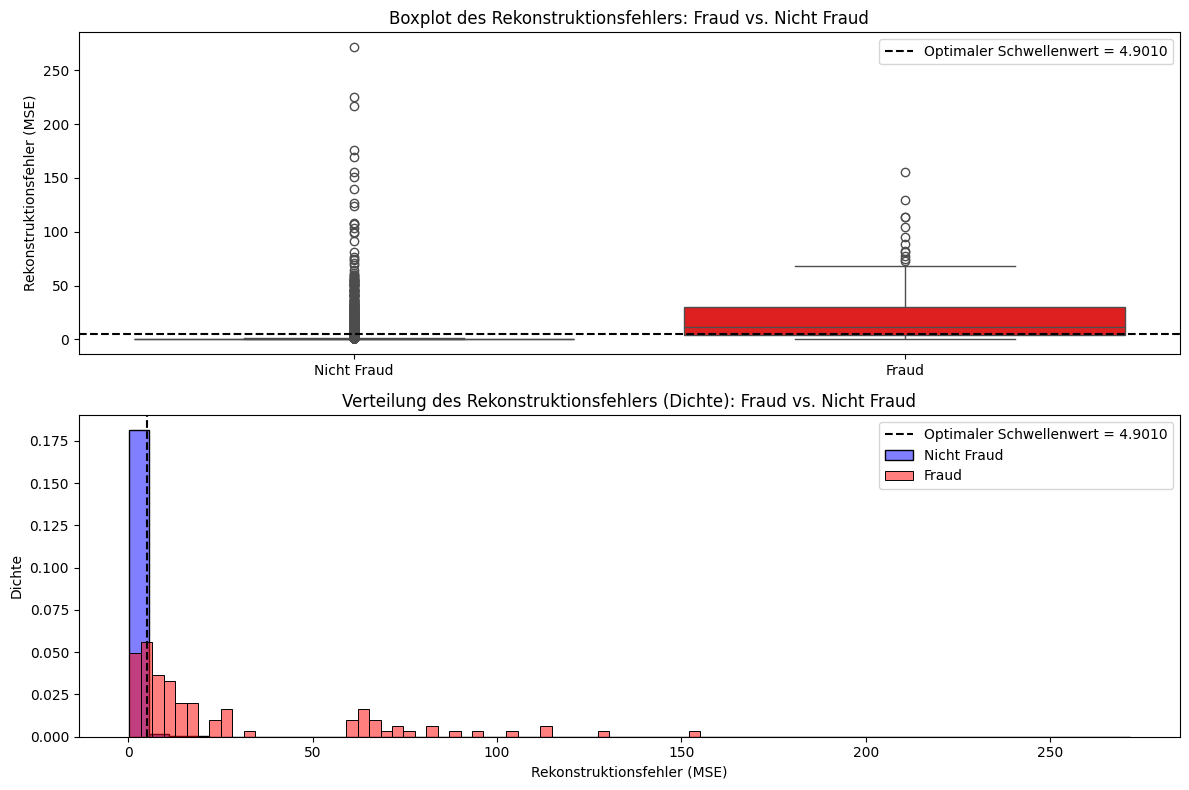

In [ ]:
plot_reconstruction_analysis(
    svae,
    X_test,
    np.squeeze(y_test),  # Squeeze y_test, um (n_samples,) zu erhalten
    threshold=optimal_threshold,
    folder_name="vae_results/reconstruction_analysis"
)

##4. Plot AUC ROC

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Performance:
Accuracy: 0.9991
Precision: 0.8182
Recall: 0.6429
F1 Score: 0.7200


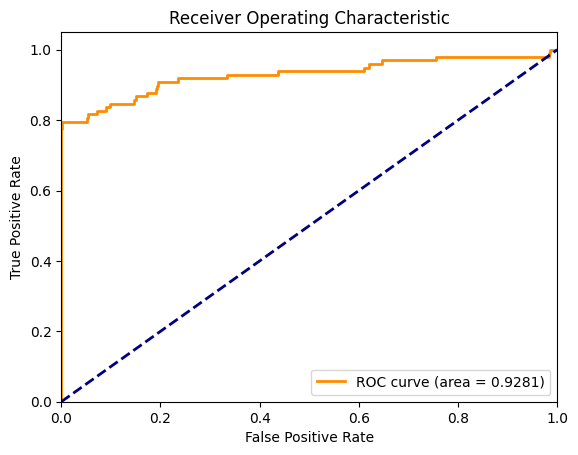

In [ ]:
# Evaluate the classifier on test data
_,_,_, y_pred_prob_svae = svae.predict(X_test)
y_pred_svae = (y_pred_prob_svae > 0.5).astype(int)  # Apply threshold at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svae)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svae, average='binary')

print(f"Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_svae)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Classifikation report

In [ ]:
classification_report_svae = classification_report(y_test, y_pred_svae)
print(classification_report_svae)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.82      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



## 5.Plotten des latenten Raums

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/svae_results/latent_space/latent_space_SupervisedVAE_20250301_082502.png


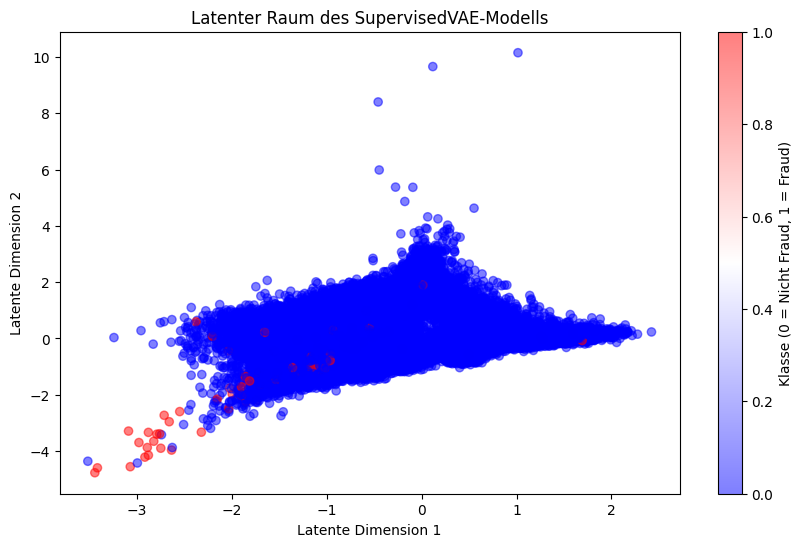

In [ ]:
plot_latent_space(
    svae,
    X_test,
    np.squeeze(y_test),  # Squeeze y_test, um (n_samples,) zu erhalten
    folder_name="svae_results/latent_space"
)

_______________________________________________________

---



#V. Threshold-Sensitivitätsanalyse

In [ ]:
X = df.drop('Class', axis=1).values
y = df['Class'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Konvertiere zu float32 und forme y zu (batch_size, 1) für Supervised-Modelle
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.expand_dims(y_train.astype(np.float32), axis=-1)  # Shape (n_samples, 1) für Supervised
y_test = np.expand_dims(y_test.astype(np.float32), axis=-1)    # Shape (n_samples, 1) für Supervised
y_train_unsupervised = y_train.flatten()  # Eindimensional für Unsupervised (nur normale Daten)
y_test_unsupervised = y_test.flatten()

# Debugging
print("X_train shape:", X_train.shape)
print("y_train shape (Supervised):", y_train.shape, "Unique values:", np.unique(y_train))
print("X_test shape:", X_test.shape)
print("y_test shape (Supervised):", y_test.shape, "Unique values:", np.unique(y_test))

X_train shape: (227845, 29)
y_train shape (Supervised): (227845, 1) Unique values: [0. 1.]
X_test shape: (56962, 29)
y_test shape (Supervised): (56962, 1) Unique values: [0. 1.]


In [ ]:
# Modellinstanziierung
models = {
    'UnsupervisedAE': UnsupervisedAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=32,
        activation='mish',
        dropout_rate=0.1
    ),
    'UnsupervisedVAE': UnsupervisedVAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=16,
        activation='mish',
        dropout_rate=0.1,
        kl_weight=1.0
    ),
    'SupervisedAE': SupervisedAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=32,
        classifier_dims=[16],
        activation='mish',
        dropout_rate=0.1
    ),
    'SupervisedVAE': SupervisedVAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=16,
        classifier_dims=[16],
        activation='mish',
        dropout_rate=0.1,
        kl_weight=1.0
    )
}

In [ ]:
def train_and_plot_model(model_class, model_type, X_train, y_train, X_test, y_test):
    learning_rate = 0.001  # Definieren Sie den Lernrate-Wert
    if model_type in ['uae', 'uvae']:
        # Für unüberwachte Modelle: Nur normale Daten (Class=0) verwenden
        X_train_normal = X_train[y_train.flatten() == 0]
        model = model_class(
            input_dim=X_train.shape[1],
            latent_dim=16,
            hidden_dims=[64, 32],
            activation='mish',
            dropout_rate=0.1
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        history = model.fit(X_train_normal, epochs=5, batch_size=256,validation_split=0.1, verbose=0)
    else:  # 'sae', 'svae'
        model = model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=16,
            classifier_dims=[16],
            activation='mish',
            dropout_rate=0.1
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        history = model.fit(X_train,y_train, epochs=5, validation_split=0.1, verbose=0)

    fig, axes = plot_loss_curves(
        history,
        model_type=model_type,
        folder_name="all_results/loss_curves"
    )
    #model.save_model_to_drive()



In [ ]:
# Trainieren und plotten für jedes Modell
for model_class, model_type in [
    (UnsupervisedAE, 'uae'),
    (UnsupervisedVAE, 'uvae'),
    (SupervisedAE, 'sae'),
    (SupervisedVAE, 'svae')
]:
    print(f"\nTraining und Plotten für {model_type.upper()}...")
    train_and_plot_model(model_class, model_type, X_train, y_train, X_test, y_test)


Training und Plotten für UAE...
Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_uae_20250301_093813.png

Training und Plotten für UVAE...
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_uvae_20250301_093857.png

Training und Plotten für SAE...
Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_sae_20250301_094229.png

Training und Plotten für SVAE...
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_svae_20250301_094501.png


In [ ]:
for model_name, model in models.items():
    print(f"\nThreshold-Sensitivitätsanalyse für {model_name}...")

    # Berechnung des Rekonstruktionsfehlers
    reconstruction_error = calculate_reconstruction_error(model, X_test)

    # Testen verschiedener Schwellenwerte
    thresholds = np.arange(0.1, 5.0, 0.1)
    f1_scores = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        fraud_predictions = detect_fraud(model, X_test, threshold=threshold)
        metrics = evaluate_fraud_detection(model, X_test, np.squeeze(y_test), threshold=threshold, save_metrics=False)
        f1_scores.append(metrics['F1-Score'])
        precisions.append(metrics['Precision'])
        recalls.append(metrics['Recall'])

    # Visualisierung
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.title(f"Threshold-Sensitivitätsanalyse für {model_name}")
    plt.xlabel("Schwellenwert")
    plt.ylabel("Metrik")
    plt.legend()
    plt.grid(True)

    # Speichern in Google Drive
    base_dir = "/content/drive/MyDrive"
    folder_path = os.path.join(base_dir, f"vae_results/threshold_sensitivity_{model_name.lower()}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(folder_path, f"threshold_sensitivity_{model_name}_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Threshold-Sensitivitätsplot wurde gespeichert unter: {save_path}")
    best_f1 = max(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Bester F1-Score: {best_f1:.4f} bei Schwellenwert {best_threshold:.2f}")


Threshold-Sensitivitätsanalyse für UnsupervisedAE...

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0018
ROC-AUC: 0.5000

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.02      0.03     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.03     56962


Metriken:
Precision: 0.0018
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0194
ROC-AUC: 0.5089

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0020
ROC-AUC: 0.5001

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.02      0.04     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.04     56962


Metriken:
Precision: 0.0018
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0200
ROC-AUC: 0.5092

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0018
ROC-AUC: 0.5000

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.02      0.04     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.04     56962


Metriken:
Precision: 0.0018
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0197
ROC-AUC: 0.5090

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0018
ROC-AUC: 0.5000

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.01      0.02     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.01     56962
   macro avg       0.50      0.51      0.01     56962
weighted avg       1.00      0.01      0.02     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0141
ROC-AUC: 0.5062

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

# VI. Hyperparameter-Tuining

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold

## Hilffunktion um Modell zu erstellen

In [ ]:
def create_model(model_class, latent_dim, activation, dropout_rate, kl_weight=None, classifier_dims=None):
    if model_class in [UnsupervisedVAE, SupervisedVAE]:
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            activation=activation,
            dropout_rate=dropout_rate,
            kl_weight=kl_weight if kl_weight is not None else 1.0
        )
    elif model_class == SupervisedAE:
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            classifier_dims=classifier_dims,  # Einzelne Schicht für SAE
            activation=activation,
            dropout_rate=dropout_rate
        )
    else:  # UnsupervisedAE
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            activation=activation,
            dropout_rate=dropout_rate
        )

## Optuna-Studien für jedes Modell


In [ ]:
# Vorbereitung der Daten für Optuna (reduzierte Untermenge für schnellere Ausführung)
X_train_subset = X_train[:10000]  # Reduziere auf 10,000 Beispiele
y_train_subset_unsupervised = y_train_unsupervised[:10000]  # Für Unsupervised
y_train_subset_supervised = y_train[:10000]  # Für Supervised

In [ ]:
# StratifiedKFold für Kreuzvalidierung (5 Folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Daten vorbereitet. Shapes:", X_train.shape, y_train.shape)

Daten vorbereitet. Shapes: (227845, 29) (227845, 1)


In [ ]:
# Dictionary zur Speicherung der besten Parameter
best_params_dict = {}

In [ ]:
import json # Import the json module
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Dictionary zur Speicherung der besten Parameter
best_params_dict = {}

# Optimierung nur für UnsupervisedAE
model_class = UnsupervisedAE
model_type = 'uae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_uae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
def objective_ae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish',"swish"])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)

    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,latent_dim, activation, dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        # Baue das Modell
        X_train_normal_fold = X_train_fold[y_train_fold.flatten() == 0]
        if len(X_train_normal_fold) == 0:
            raise ValueError("Keine normalen Daten gefunden!")
        model.build(input_shape=(None, X_train_normal_fold.shape[1]))
        history = model.fit(X_train_normal_fold, epochs=5, batch_size=128, validation_data=(X_val_fold[y_val_fold.flatten() == 0], None), verbose=0)

        # Berechne Rekonstruktionsfehler für Validierungsdaten
        recon_error = calculate_reconstruction_error(model, X_val_fold)
        if np.any(np.isnan(recon_error)):
            recon_error = np.nan_to_num(recon_error, nan=np.mean(recon_error))
        roc_auc = roc_auc_score(y_val_fold.flatten(), recon_error)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc


# Führe 20 Trials durch
study_uae.optimize(objective_ae, n_trials=10)

# Speichere die besten Parameter
best_params = study_uae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_uae.best_value:.4f}")

[I 2025-03-01 21:19:01,371] A new study created in memory with name: no-name-cdc73545-1a4a-4c24-b435-200faaf2f788



Starte Hyperparameter-Optimierung mit Optuna für UnsupervisedAE (ROC-AUC mit StratifiedKFold)...


[I 2025-03-01 21:21:26,557] Trial 0 finished with value: 0.9524401268296548 and parameters: {'latent_dim': 16, 'activation': 'mish', 'learning_rate': 0.00011543278512327914, 'dropout_rate': 0.0026749137722337003}. Best is trial 0 with value: 0.9524401268296548.
[I 2025-03-01 21:23:20,935] Trial 1 finished with value: 0.952302986565328 and parameters: {'latent_dim': 8, 'activation': 'swish', 'learning_rate': 0.0040116139225152, 'dropout_rate': 0.05180507066404969}. Best is trial 0 with value: 0.9524401268296548.
[I 2025-03-01 21:25:28,341] Trial 2 finished with value: 0.9532522981594104 and parameters: {'latent_dim': 2, 'activation': 'mish', 'learning_rate': 0.0003977025167838734, 'dropout_rate': 0.19580843414266733}. Best is trial 2 with value: 0.9532522981594104.
[I 2025-03-01 21:27:28,923] Trial 3 finished with value: 0.9519040206337975 and parameters: {'latent_dim': 2, 'activation': 'relu', 'learning_rate': 0.007328614755189857, 'dropout_rate': 0.04115394967270987}. Best is trial 2 

Beste Parameter für UnsupervisedAE: {'latent_dim': 2, 'activation': 'relu', 'learning_rate': 0.001511465327714308, 'dropout_rate': 0.18605883720194}
Bester durchschnittlicher ROC-AUC (5-Fold): 0.9535


<ipython-input-58-f7ad013fdfa5>:5: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

<ipython-input-58-f7ad013fdfa5>:6: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



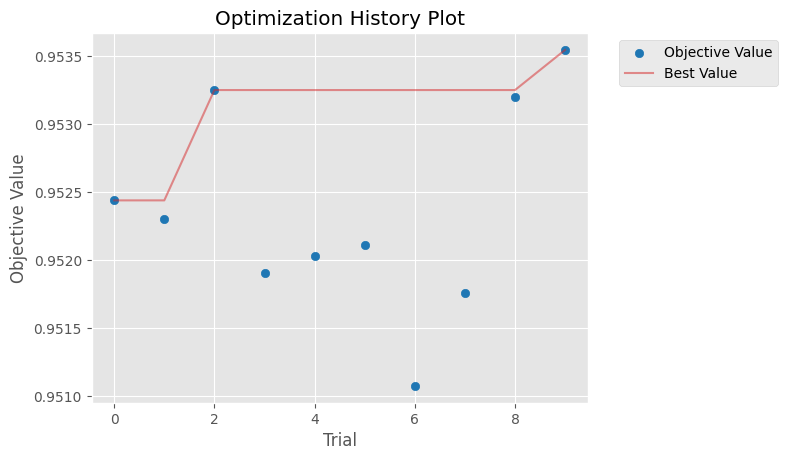

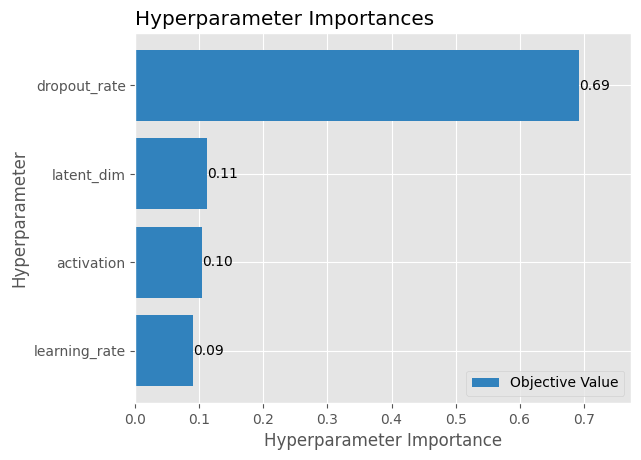

In [ ]:
import matplotlib.pyplot as plt

# UAE
axes[0, 0].set_title('UAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_uae)
optuna.visualization.matplotlib.plot_param_importances(study_uae)
fig.show()

## Optuna VAE

In [ ]:
# Dictionary zur Speicherung der besten Parameter
# Optimierung nur für UnsupervisedAE
model_class = UnsupervisedVAE
model_type = 'uvae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_uvae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
def objective_uvae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish',"swish"])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    kl_weight = trial.suggest_float('kl_weight', 0.5, 2.0)
    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,latent_dim, activation, dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        # Baue das Modell
        X_train_normal_fold = X_train_fold[y_train_fold.flatten() == 0]
        if len(X_train_normal_fold) == 0:
            raise ValueError("Keine normalen Daten gefunden!")
        model.build(input_shape=(None, X_train_normal_fold.shape[1]))
        history = model.fit(X_train_normal_fold, epochs=5, batch_size=64, validation_data=(X_val_fold[y_val_fold.flatten() == 0], None), verbose=0)

        # Berechne Rekonstruktionsfehler für Validierungsdaten
        recon_error = calculate_reconstruction_error(model, X_val_fold)
        if np.any(np.isnan(recon_error)):
            recon_error = np.nan_to_num(recon_error, nan=np.finfo(recon_error.dtype).max)
        roc_auc = roc_auc_score(y_val_fold.flatten(), recon_error)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc


# Führe 20 Trials durch
study_uvae.optimize(objective_uvae, n_trials=10)

# Speichere die besten Parameter
best_params = study_uvae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_uvae.best_value:.4f}")


[I 2025-03-01 22:22:47,084] A new study created in memory with name: no-name-22db5762-ef66-40a6-893d-a11c1dc0ef31



Starte Hyperparameter-Optimierung mit Optuna für UnsupervisedVAE (ROC-AUC mit StratifiedKFold)...


[I 2025-03-01 22:29:10,951] Trial 0 finished with value: 0.6815986641499757 and parameters: {'latent_dim': 8, 'activation': 'swish', 'learning_rate': 0.009141645316304509, 'dropout_rate': 0.1287591411256764, 'kl_weight': 1.0207836873268523}. Best is trial 0 with value: 0.6815986641499757.
[I 2025-03-01 22:36:42,742] Trial 1 finished with value: 0.9527710754438194 and parameters: {'latent_dim': 2, 'activation': 'mish', 'learning_rate': 0.0006584784838204952, 'dropout_rate': 0.17107994679931565, 'kl_weight': 0.5399747870696118}. Best is trial 1 with value: 0.9527710754438194.
[I 2025-03-01 22:44:36,887] Trial 2 finished with value: 0.9538653973621279 and parameters: {'latent_dim': 16, 'activation': 'mish', 'learning_rate': 0.00016379626343164197, 'dropout_rate': 0.031870946623092665, 'kl_weight': 1.7476191284152147}. Best is trial 2 with value: 0.9538653973621279.
[I 2025-03-01 22:51:21,635] Trial 3 finished with value: 0.9562085316815155 and parameters: {'latent_dim': 2, 'activation': '

Beste Parameter für UnsupervisedVAE: {'latent_dim': 2, 'activation': 'mish', 'learning_rate': 0.0002129245143569626, 'dropout_rate': 0.04612158099861335, 'kl_weight': 1.4441870859313692}
Bester durchschnittlicher ROC-AUC (5-Fold): 0.9564


<ipython-input-66-e7b765d392a7>:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

<ipython-input-66-e7b765d392a7>:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



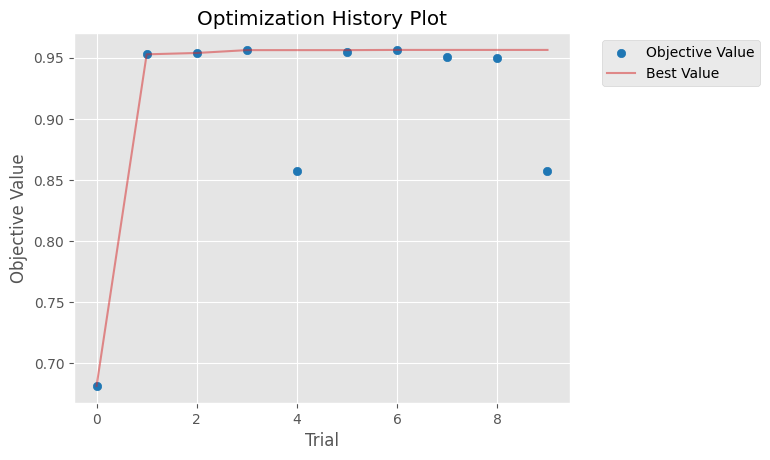

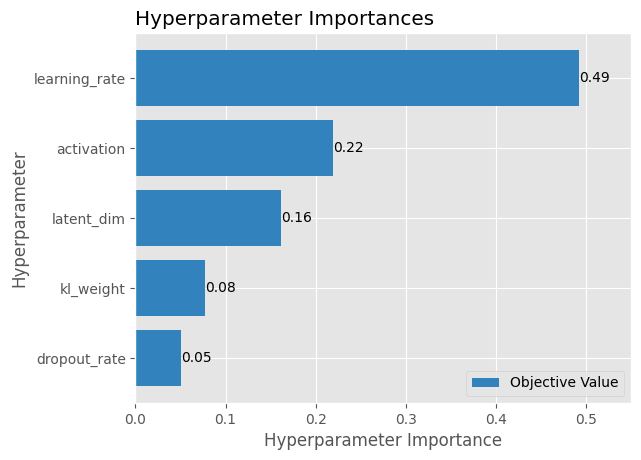

In [66]:
# UAE
axes[0, 0].set_title('UAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_uvae)
optuna.visualization.matplotlib.plot_param_importances(study_uvae)
fig.show()

## Optuna mit SAE

In [88]:
classifier_dims = [16,8]
# Optimierung nur für SupervisedAE
model_class = SupervisedAE
model_type = 'sae'
model_name = model_class.__name__
print(f"\nStarte Hyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

# Erstelle eine Optuna-Studie
study_sae = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

def objective_sae(trial):
    # Hyperparameter-Suchraum
    latent_dim = trial.suggest_categorical('latent_dim', [2, 8, 16])
    activation = trial.suggest_categorical('activation', ['relu', 'mish', 'swish'])
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)
    l2_lambda = trial.suggest_float('l2_lambda', 0.001, 0.1, log=True)  # L2-Regularisierungsfaktor optimieren
    # Initialisiere ROC-AUC über die Folds
    roc_auc_scores = []

    # StratifiedKFold für robuste Evaluierung
    for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Erstelle und kompiliere das Modell
        model = create_model(model_class,latent_dim,
            classifier_dims=classifier_dims,  # Pass classifier_dims here
            activation=activation,
            dropout_rate=dropout_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        # Baue das Modell
        model.build(input_shape=(None, X_train_fold.shape[1]))
        history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)

        # Berechne Klassifikations-ROC-AUC
        preds = (model.classify(model.encode(tf.convert_to_tensor(X_val_fold, dtype=tf.float32)))>0.5).numpy()
        roc_auc = roc_auc_score(y_val_fold.flatten(), preds)

        roc_auc_scores.append(roc_auc)

    # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
    mean_roc_auc = np.mean(roc_auc_scores)
    return mean_roc_auc
# Führe 20 Trials durch
study_sae.optimize(objective_sae, n_trials=10)

# Speichere die besten Parameter
best_params = study_sae.best_params
best_params_dict[model_name] = best_params
print(f"Beste Parameter für {model_name}: {best_params}")
print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study_sae.best_value:.4f}")

[I 2025-03-02 03:32:27,461] A new study created in memory with name: no-name-e5e6011a-d6e4-4b76-9af6-7ae52001b971



Starte Hyperparameter-Optimierung mit Optuna für SupervisedAE (ROC-AUC mit StratifiedKFold)...


[I 2025-03-02 03:40:00,462] Trial 0 finished with value: 0.8007796147310868 and parameters: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.0030415972814613022, 'dropout_rate': 0.07172045417321903, 'l2_lambda': 0.0029612976444337025}. Best is trial 0 with value: 0.8007796147310868.
[I 2025-03-02 03:47:38,118] Trial 1 finished with value: 0.8490299759109057 and parameters: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.00011881407237894337, 'dropout_rate': 0.005138727211745376, 'l2_lambda': 0.029131633167917795}. Best is trial 1 with value: 0.8490299759109057.
[I 2025-03-02 03:55:02,005] Trial 2 finished with value: 0.7535984595397645 and parameters: {'latent_dim': 2, 'activation': 'swish', 'learning_rate': 0.00011054676055988568, 'dropout_rate': 0.15421772752222093, 'l2_lambda': 0.019860440622427877}. Best is trial 1 with value: 0.8490299759109057.
[I 2025-03-02 04:02:25,294] Trial 3 finished with value: 0.6942631943893278 and parameters: {'latent_dim': 2, 'activ

Beste Parameter für SupervisedAE: {'latent_dim': 8, 'activation': 'relu', 'learning_rate': 0.00011881407237894337, 'dropout_rate': 0.005138727211745376, 'l2_lambda': 0.029131633167917795}
Bester durchschnittlicher ROC-AUC (5-Fold): 0.8490


<ipython-input-89-5ac36d396884>:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.

<ipython-input-89-5ac36d396884>:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



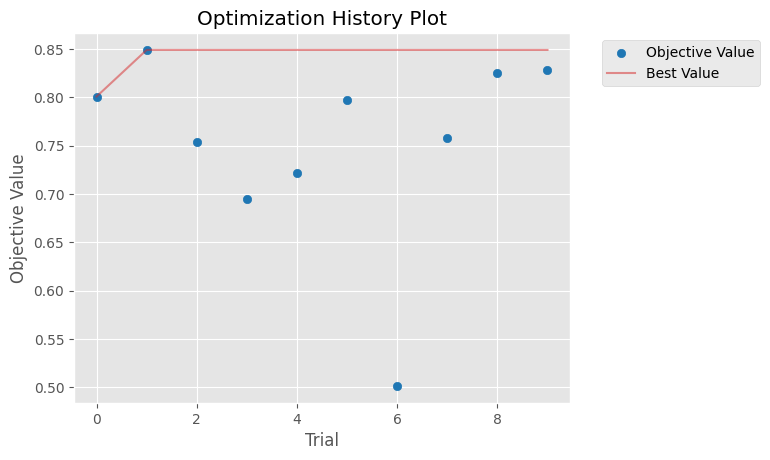

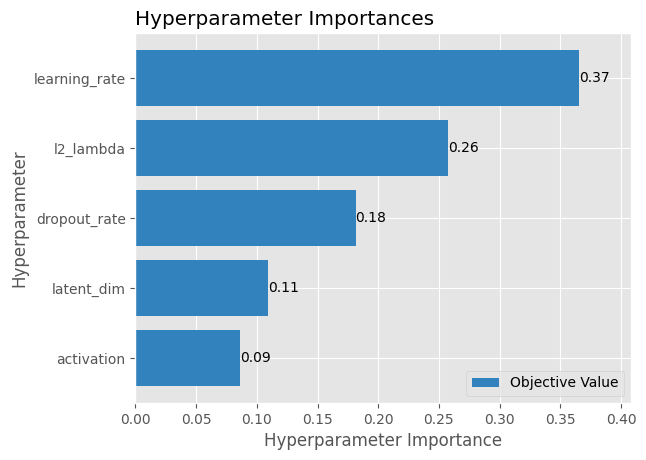

In [89]:
# SAE
axes[0, 0].set_title('SAE Hyperparameter Optimization')
optuna.visualization.matplotlib.plot_optimization_history(study_sae)
optuna.visualization.matplotlib.plot_param_importances(study_sae)
fig.show()

## 1optun SVAE

## Ergebnisse Visualiseren